In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2

## 一、canny detail

In [3]:
pic_path = 'lenna.png'
img = plt.imread(pic_path) # save as 0-1, transform 0-255
if pic_path[-4:] == '.png':
    img = img * 255

In [4]:
# transform it to grap picture
img = img.mean(axis = -1)

### 1、高斯平滑

(-0.5, 511.5, 511.5, -0.5)

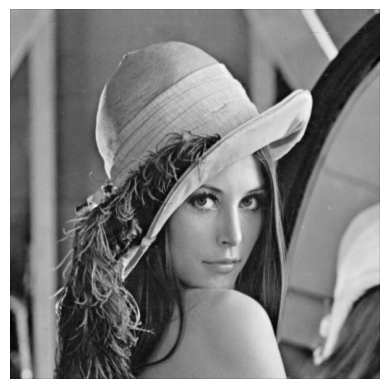

In [5]:
sigma = 0.5 # standard deviation
dim = int(np.round( 6 * sigma + 1 )) #  dimensionality
if dim % 2 ==0:
    dim+=1
Gaussian_filter = np.zeros([dim,dim])
tmp = [i-dim//2 for i in range(dim)] # [-2, -1, 0, 1, 2]
n1 = 1/(2 * math.pi * sigma**2)
n2 = -1/(2*sigma**2)
for i in range(dim):
    for j in range(dim):
        Gaussian_filter[i,j] = n1 * math.exp(n2*(tmp[i]**2+tmp[j]**2))
Gaussian_filter = Gaussian_filter / Gaussian_filter.sum()

dx,dy = img.shape
img_new = np.zeros(img.shape)
tmp = dim//2
img_pad = np.pad(img,((tmp, tmp), (tmp, tmp)), 'constant')
# ((tmp, tmp), (tmp, tmp)) 向上、向下、向左、向右，填tmp行
for i in range(dx):
    for j in range(dy):
        img_new[i,j] = np.sum(img_pad[i:i+dim,j:j+dim]*Gaussian_filter)
plt.figure(1)
plt.imshow(img_new.astype(np.uint8), cmap='gray')
plt.axis('off')

### 2、求梯度

In [6]:
sobel_kernel_x = np.array([[-1, 0, 1],
                           [-2, 0, 2],
                           [-1, 0, 1]])
sobel_kernel_y = np.array([[1, 2, 1],
                           [0, 0, 0],
                           [-1, -2, -1]])

In [7]:
img_tidu_x = np.zeros(img_new.shape)
img_tidu_y = np.zeros([dx, dy])

In [8]:
img_tidu = np.zeros(img_new.shape)
img_pad = np.pad(img_new, ((1, 1), (1, 1)), 'constant')

In [9]:
for i in range(dx):
    for j in range(dy):
        img_tidu_x[i,j] = np.sum(img_pad[i:i+3,j:j+3]*sobel_kernel_x)
        img_tidu_y[i, j] = np.sum(img_pad[i:i+3, j:j+3]*sobel_kernel_y)
        img_tidu[i,j] = np.sqrt(img_tidu_x[i,j]**2+img_tidu_y[i, j]**2)

(-0.5, 511.5, 511.5, -0.5)

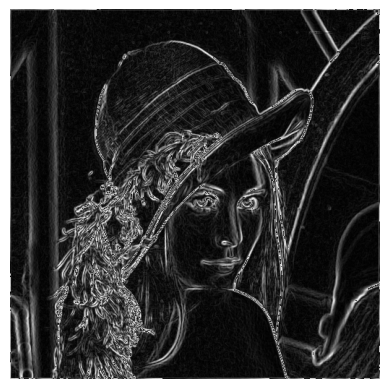

In [10]:
img_tidu_x[img_tidu_x == 0] = 0.00000001
angle = img_tidu_y/img_tidu_x
plt.figure(2)
plt.imshow(img_tidu.astype(np.uint8), cmap='gray')
plt.axis('off')

### 3、非极大值抑制

In [19]:
img_restrain = np.zeros(img_tidu.shape)

In [20]:
for i in range(1,dx-1):
    for j in range(1,dy-1):
        flag = True 
        temp = img_tidu[i-1:i+2,j-1:j+2]
        if angle[i, j] <= -1:  # 利用tan判断位于四象限的具体位置
            num_1 = (temp[0, 1] - temp[0, 0]) / angle[i, j] + temp[0, 1]
            num_2 = (temp[2, 1] - temp[2, 2]) / angle[i, j] + temp[2, 1]
            if not (img_tidu[i, j] > num_1 and img_tidu[i, j] > num_2):
                flag = False
        elif angle[i, j] >= 1:
            num_1 = (temp[0, 2] - temp[0, 1]) / angle[i, j] + temp[0, 1]
            num_2 = (temp[2, 0] - temp[2, 1]) / angle[i, j] + temp[2, 1]
            if not (img_tidu[i, j] > num_1 and img_tidu[i, j] > num_2):
                flag = False
        elif angle[i, j] > 0:
            num_1 = (temp[0, 2] - temp[1, 2]) * angle[i, j] + temp[1, 2]
            num_2 = (temp[2, 0] - temp[1, 0]) * angle[i, j] + temp[1, 0]
            if not (img_tidu[i, j] > num_1 and img_tidu[i, j] > num_2):
                flag = False
        elif angle[i, j] < 0:
            num_1 = (temp[1, 0] - temp[0, 0]) * angle[i, j] + temp[1, 0]
            num_2 = (temp[1, 2] - temp[2, 2]) * angle[i, j] + temp[1, 2]
            if not (img_tidu[i, j] > num_1 and img_tidu[i, j] > num_2):
                flag = False
        if flag:
            img_restrain[i, j] = img_tidu[i, j]

(-0.5, 511.5, 511.5, -0.5)

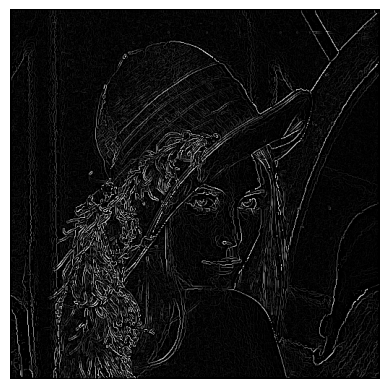

In [21]:
plt.figure(3)
plt.imshow(img_restrain.astype(np.uint8), cmap='gray')
plt.axis('off')

#### 4、双阈值检测

In [22]:
lower_boundary = img_tidu.mean() * 0.5
high_boundary = lower_boundary * 3
zhan = []
for i in range(1,img_restrain.shape[0]-1):
    for j in range(1,img_restrain.shape[1]-1):
        if img_restrain[i,j] >= high_boundary:
            img_restrain[i,j] = 255
            zhan.append([i,j])
        elif img_restrain[i,j] <= lower_boundary:
            img_restrain[i,j] = 0

In [23]:
while not len(zhan) == 0:
    temp_1, temp_2 = zhan.pop() # move the final value, and give it to variable
    a = img_restran[temp_1-1:temp_1+2, temp_2-1:temp_2+2]
    if (a[0, 0] < high_boundary) and (a[0, 0] > lower_boundary):
        img_restran[temp_1-1, temp_2-1] = 255  
        zhan.append([temp_1-1, temp_2-1])  
    if (a[0, 1] < high_boundary) and (a[0, 1] > lower_boundary):
        img_restran[temp_1 - 1, temp_2] = 255
        zhan.append([temp_1 - 1, temp_2])
    if (a[0, 2] < high_boundary) and (a[0, 2] > lower_boundary):
        img_restran[temp_1 - 1, temp_2 + 1] = 255
        zhan.append([temp_1 - 1, temp_2 + 1])
    if (a[1, 0] < high_boundary) and (a[1, 0] > lower_boundary):
        img_restran[temp_1, temp_2 - 1] = 255
        zhan.append([temp_1, temp_2 - 1])
    if (a[1, 2] < high_boundary) and (a[1, 2] > lower_boundary):
        img_restran[temp_1, temp_2 + 1] = 255
        zhan.append([temp_1, temp_2 + 1])
    if (a[2, 0] < high_boundary) and (a[2, 0] > lower_boundary):
        img_restran[temp_1 + 1, temp_2 - 1] = 255
        zhan.append([temp_1 + 1, temp_2 - 1])
    if (a[2, 1] < high_boundary) and (a[2, 1] > lower_boundary):
        img_restran[temp_1 + 1, temp_2] = 255
        zhan.append([temp_1 + 1, temp_2])
    if (a[2, 2] < high_boundary) and (a[2, 2] > lower_boundary):
        img_restran[temp_1 + 1, temp_2 + 1] = 255
        zhan.append([temp_1 + 1, temp_2 + 1])

In [24]:
for i in range(img_restrain.shape[0]):
    for j in range(img_restrain.shape[1]):
        if img_restrain[i,j] != 0 and img_restrain[i,j] != 255:
            img_restrain[i,j]=0

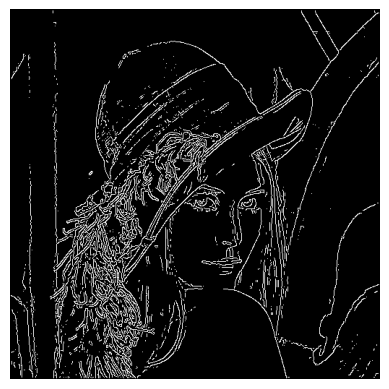

In [26]:
# 绘图
plt.figure(4)
plt.imshow(img_restrain.astype(np.uint8), cmap='gray')
plt.axis('off')  # 关闭坐标刻度值
plt.show()

## 二、canny simple

### 1.普通

In [2]:
img = cv2.imread("lenna.png",1)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
cv2.imshow("canny", cv2.Canny(gray, 200, 300))
cv2.waitKey()
cv2.destroyAllWindows()

## 2.进化版本

这个还没有弄懂，先suspend了，后边有空在review了

In [3]:
def CannyThreshold(lowThreshold):  
    detected_edges = cv2.GaussianBlur(gray,(3,3),0) #高斯滤波 
    detected_edges = cv2.Canny(detected_edges,
            lowThreshold,
            lowThreshold*ratio,
            apertureSize = kernel_size)  #边缘检测
 
     # just add some colours to edges from original image.  
    dst = cv2.bitwise_and(img,img,mask = detected_edges)  #用原始颜色添加到检测的边缘上
    cv2.imshow('canny demo',dst) 

In [4]:
lowThreshold = 0  
max_lowThreshold = 100  
ratio = 3  
kernel_size = 3  
  
img = cv2.imread('lenna.png')  
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  #转换彩色图像为灰度图
  
cv2.namedWindow('canny demo')  

In [5]:
cv2.createTrackbar('Min threshold','canny demo',lowThreshold, max_lowThreshold, CannyThreshold)  
  
CannyThreshold(0)  # initialization  
if cv2.waitKey(0) == 27:  #wait for ESC key to exit cv2
    cv2.destroyAllWindows()  